In [1]:
import sys

sys.version_info

sys.version_info(major=3, minor=11, micro=2, releaselevel='final', serial=0)

### Run these commands as needed

In [2]:
# !sudo apt update  && sudo apt-get install libsndfile1 ffmpeg -y 

# !pip install --upgrade  numpy scipy matplotlib librosa==0.9.2 soundfile==0.11.0
# !pip install --upgrade setuptools

# Demonstrates calculating divergence measures (KL, JS, KS)
## Compare acoustic fingerprints (MFCCs) of two audio files.


In [3]:
import librosa
import librosa.display
import numpy as np
from scipy.stats import gaussian_kde, ks_2samp
import matplotlib.pyplot as plt

N_MFCC = 13 # Number of MFCC coefficients to extract

# Small epsilon to prevent log(0) or division by zero issues
EPSILON = 1e-10

In [4]:
def load_audio(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        print(f"Loaded '{file_path}' (duration: {librosa.get_duration(y=y, sr=sr):.2f}s, sr: {sr} Hz)")
        return y, sr
    except Exception as e:
        print(f"Error loading audio file {file_path}: {e}")
        return None, None

def extract_mfccs(y, sr, n_mfcc=13):
    """Extracts MFCC features from audio data."""
    try:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        print(f"Extracted MFCCs with shape: {mfccs.shape}")
        return mfccs
    except Exception as e:
        print(f"Error extracting MFCCs: {e}")
        return None

def preprocess_mfccs_for_1d_analysis(mfccs):
    """Preprocesses MFCCs for 1D distribution analysis."""
    if mfccs is None or mfccs.shape[0] == 0:
        return np.array([])
    # Using the first MFCC coefficient (index 0)
    mfcc_feature = mfccs[0, :]
    print(f"Using 1st MFCC coefficient for analysis (shape: {mfcc_feature.shape})")
    return mfcc_feature

def estimate_pdf(data, num_points=500):
    """
    Estimates the Probability Density Function (PDF) using Gaussian KDE.
    """
    if data is None or len(data) < 2: 
         print("Not enough data points for KDE.")
         return None, None, None
    try:
        kde = gaussian_kde(data)
        # Determine range for evaluation
        data_min, data_max = data.min(), data.max()
        padding = (data_max - data_min) * 0.1 # padding
        x_eval = np.linspace(data_min - padding, data_max + padding, num_points)
        pdf_values = kde(x_eval)
        return kde, x_eval, pdf_values
    except Exception as e:
        print(f"Error during KDE estimation: {e}")
        return None, None, None

def calculate_kl_divergence(p, q):
    """
    Calculate Kullback-Leibler (KL) divergence.
    """
    p_norm = p / np.sum(p)
    q_norm = q / np.sum(q)
    p_safe = p_norm + EPSILON
    q_safe = q_norm + EPSILON
    
    try:
        kl_div = np.sum(p_safe * np.log(p_safe / q_safe))
        return kl_div
    except Exception as e:
        print(f"Error calculating KL divergence: {e}")
        return np.inf


def calculate_js_divergence(p, q):
    """
    Calculate Jensen-Shannon (JS) divergence
    """
    try:
        p_norm = p / np.sum(p)
        q_norm = q / np.sum(q)
        p_safe = p_norm + EPSILON
        q_safe = q_norm + EPSILON

        m = 0.5 * (p_safe + q_safe)
        
        js_div = 0.5 * (calculate_kl_divergence(p_safe, m) + calculate_kl_divergence(q_safe, m))
        return js_div
    except Exception as e:
        print(f"Error calculating JS divergence: {e}")
        return np.inf


def calculate_ks_statistic(data1, data2):
    """
    Calculate 2-sample Kolmogorov-Smirnov (KS) test.
    """
    if data1 is None or data2 is None or len(data1) == 0 or len(data2) == 0:
        print("Not enough data for KS test.")
        return None, None
    try:
        ks_statistic, p_value = ks_2samp(data1, data2)
        return ks_statistic, p_value
    except Exception as e:
        print(f"Error performing KS test: {e}")
        return None, None

def plot_distributions(x_eval, pdf1, pdf2, label1='Audio 1', label2='Audio 2', feature_name='1st MFCC Coefficient', title='Distribution Comparison'):
    """
    Plots the estimated PDFs of the two distributions.
    """
    if x_eval is None or pdf1 is None or pdf2 is None:
        print("Cannot plot distributions due to missing data.")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(x_eval, pdf1, label=f'{label1} PDF', linewidth=2)
    plt.plot(x_eval, pdf2, label=f'{label2} PDF', linestyle='--', linewidth=2)
    plt.xlabel(f'{feature_name} Value')
    plt.ylabel('Probability Density')
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()



In [5]:
!ls -lh *.wav

-rw-r--r-- 1 vscode vscode 4.8M Apr 25 19:55 127389__acclivity__thetimehascome.wav
-rw-r--r-- 1 vscode vscode 2.0M Apr 25 19:55 352762__kennysvoice__audiokingsz-illusion.wav


In [6]:
AUDIO_FILE_1 = "./127389__acclivity__thetimehascome.wav"
AUDIO_FILE_2 = "./352762__kennysvoice__audiokingsz-illusion.wav"

## Acoustic Fingerprint Comparison

In [7]:
import audioread
import os

if not os.path.exists(AUDIO_FILE_1):
    print(f"{AUDIO_FILE_1} not found!")
if not os.path.exists(AUDIO_FILE_2):
    print(f"{AUDIO_FILE_2} not found!")

try:
    with audioread.audio_open(AUDIO_FILE_1) as f:
        print(f"Channels: {f.channels}, Samplerate: {f.samplerate}, Duration: {f.duration:.2f}s")
except Exception as e:
    print(f"Error opening {AUDIO_FILE_1} with audioread:", e)
    raise e


Channels: 2, Samplerate: 44100, Duration: 27.99s


Loaded './127389__acclivity__thetimehascome.wav' (duration: 27.99s, sr: 44100 Hz)
Loaded './352762__kennysvoice__audiokingsz-illusion.wav' (duration: 22.69s, sr: 44100 Hz)
Extracted MFCCs with shape: (13, 2412)
Extracted MFCCs with shape: (13, 1955)
Using 1st MFCC coefficient for analysis (shape: (2412,))
Using 1st MFCC coefficient for analysis (shape: (1955,))
Estimated PDF for ./127389__acclivity__thetimehascome.wav
Estimated PDF for ./352762__kennysvoice__audiokingsz-illusion.wav
  - KL Divergence (PDF1 || PDF2): 3.069281
  - KL Divergence (PDF2 || PDF1): 5.741799
  - JS Divergence (PDF1, PDF2): 0.358274
  - KS Statistic: 0.621591
  - KS Test p-value: 0.000000
alpha=0.05: Distributions are likely different
Visualizing Distributions


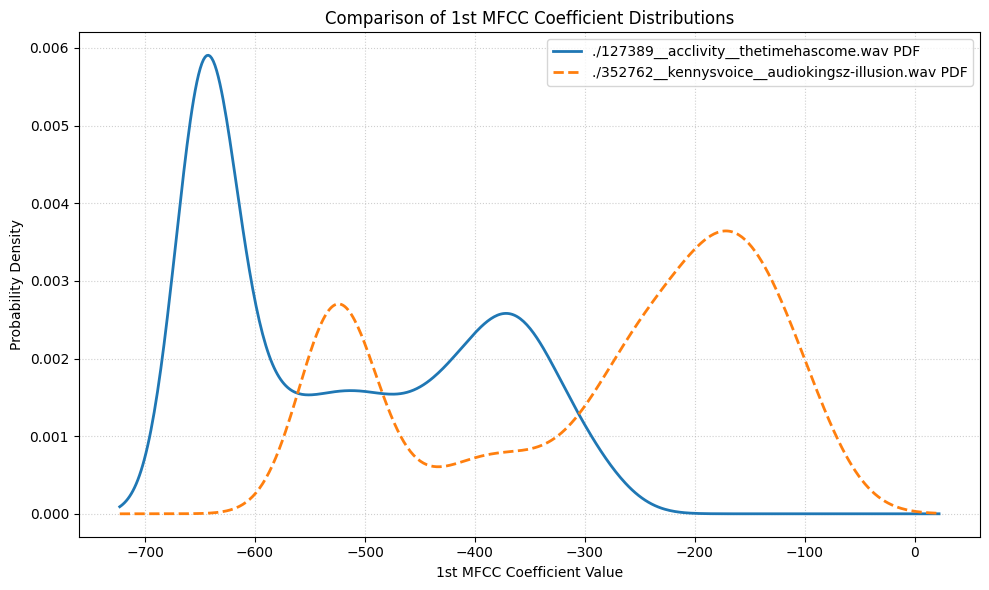

In [9]:

y1, sr1 = load_audio(AUDIO_FILE_1)
y2, sr2 = load_audio(AUDIO_FILE_2)


if sr1 != sr2:
    print(f"Sampling rates differ ({sr1} Hz vs {sr2} Hz)")
    y2 = librosa.resample(y2, orig_sr=sr2, target_sr=sr1)
    sr2 = sr1


mfccs1 = extract_mfccs(y1, sr1, n_mfcc=N_MFCC)
mfccs2 = extract_mfccs(y2, sr2, n_mfcc=N_MFCC)

if mfccs1 is None or mfccs2 is None:
    print("\nExiting due to MFCC extraction errors.")
    exit()

mfcc_data1 = preprocess_mfccs_for_1d_analysis(mfccs1)
mfcc_data2 = preprocess_mfccs_for_1d_analysis(mfccs2)

if mfcc_data1.size == 0 or mfcc_data2.size == 0:
        print("\nExiting due to lack of data after preprocessing.")
        exit()

# Evaluate PDFs over a common range determined by both datasets
combined_min = min(mfcc_data1.min(), mfcc_data2.min())
combined_max = max(mfcc_data1.max(), mfcc_data2.max())
padding = (combined_max - combined_min) * 0.1
x_eval_common = np.linspace(combined_min - padding, combined_max + padding, 500)

try:
    kde1 = gaussian_kde(mfcc_data1)
    pdf1 = kde1(x_eval_common)
    print(f"Estimated PDF for {AUDIO_FILE_1}")
except Exception as e:
    print(f"Error estimating PDF for {AUDIO_FILE_1}: {e}")
    pdf1 = None

try:
    kde2 = gaussian_kde(mfcc_data2)
    pdf2 = kde2(x_eval_common)
    print(f"Estimated PDF for {AUDIO_FILE_2}")
except Exception as e:
    print(f"Error estimating PDF for {AUDIO_FILE_2}: {e}")
    pdf2 = None

if pdf1 is not None and pdf2 is not None:
    # KL Divergence (Note: Asymmetric - D_KL(P || Q) != D_KL(Q || P))
    kl_div_12 = calculate_kl_divergence(pdf1, pdf2)
    kl_div_21 = calculate_kl_divergence(pdf2, pdf1)
    print(f"  - KL Divergence (PDF1 || PDF2): {kl_div_12:.6f}")
    print(f"  - KL Divergence (PDF2 || PDF1): {kl_div_21:.6f}")

    js_div = calculate_js_divergence(pdf1, pdf2)
    print(f"  - JS Divergence (PDF1, PDF2): {js_div:.6f}")
else:
    print("  - Could not calculate KL/JS divergence due to PDF estimation errors.")


ks_stat, ks_p_value = calculate_ks_statistic(mfcc_data1, mfcc_data2)
if ks_stat is not None:
    print(f"  - KS Statistic: {ks_stat:.6f}")
    print(f"  - KS Test p-value: {ks_p_value:.6f}")
    alpha = 0.05
    if ks_p_value < alpha:
        print(f"alpha={alpha}: Distributions are likely different")
    else:
        print(f"alpha={alpha}: distributions are not different")
else:
    print("  - Could not perform KS test.")

# 6. Visualize
print("Visualizing Distributions")
if pdf1 is not None and pdf2 is not None:
    plot_distributions(x_eval_common, pdf1, pdf2,
                        label1=f'{AUDIO_FILE_1}',
                        label2=f'{AUDIO_FILE_2}',
                        feature_name='1st MFCC Coefficient',
                        title='Comparison of 1st MFCC Coefficient Distributions')
else:
    print("  - Skipping visualization due to PDF estimation errors.")


# fin.